In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import os
import shutil
import subprocess
import re

In [2]:
ts_list = ['PGA', 'SA(0.2)', 'SA(0.5)', 'SA(1.0)', 'SA(2.0)']
ts_values = [0.01, 0.20, 0.50, 1.00, 2.00]

# Ejecución del modelo y exportación de la salida

In [3]:
!oq dbserver stop
!oq dbserver start

In [4]:
dir_route = os.getcwd()
job_route = dir_route + '/job.ini'
!oq engine --run '{job_route}'

/Users/emanuelsotoortega/Documents/DeepSkill/seismic-hazard-simulator/.env/lib/python3.11/site-packages/openquake/hazardlib/gsim/base.py:296: ExperimentalWarning: KuehnEtAl2020SInter is experimental and may change in future versions - the user is liable for their application
  warnings.warn(msg, ExperimentalWarning)
/Users/emanuelsotoortega/Documents/DeepSkill/seismic-hazard-simulator/.env/lib/python3.11/site-packages/openquake/hazardlib/gsim/base.py:296: ExperimentalWarning: KuehnEtAl2020SSlab is experimental and may change in future versions - the user is liable for their application
  warnings.warn(msg, ExperimentalWarning)
[2024-02-12 08:55:21 #21 INFO] emanuelsotoortega@MacBook-Air-de-Emanuel.local running /Users/emanuelsotoortega/Documents/DeepSkill/seismic-hazard-simulator/Case1/17_El Toro_Subduction_Crustal_VZ2019_Vs760_R300_Total Logic Tree - Option 1 - Properties modified - Site_model - Bakcarc/job.ini [--hc=None]
[2024-02-12 08:55:21 #21 INFO] Using engine version 3.18.0
[20

In [5]:
lhc = subprocess.getoutput('oq engine --lhc').split('\n')
last_hc = re.split(r'\s+', lhc[-1])
calculation_id = int(last_hc[1])

In [6]:
output_route = dir_route + '/output'

if os.path.exists(output_route):
    shutil.rmtree(output_route)

In [7]:
!oq engine --export-outputs {calculation_id} '{output_route}'

Exporting fullreport...
/Users/emanuelsotoortega/Documents/DeepSkill/seismic-hazard-simulator/.env/lib/python3.11/site-packages/openquake/hazardlib/gsim/base.py:296: ExperimentalWarning: KuehnEtAl2020SInter is experimental and may change in future versions - the user is liable for their application
  warnings.warn(msg, ExperimentalWarning)
/Users/emanuelsotoortega/Documents/DeepSkill/seismic-hazard-simulator/.env/lib/python3.11/site-packages/openquake/hazardlib/gsim/base.py:296: ExperimentalWarning: KuehnEtAl2020SSlab is experimental and may change in future versions - the user is liable for their application
  warnings.warn(msg, ExperimentalWarning)
/Users/emanuelsotoortega/Documents/DeepSkill/seismic-hazard-simulator/Case1/17_El Toro_Subduction_Crustal_VZ2019_Vs760_R300_Total Logic Tree - Option 1 - Properties modified - Site_model - Bakcarc/output/report_21.rst
Exporting hcurves...
/Users/emanuelsotoortega/Documents/DeepSkill/seismic-hazard-simulator/.env/lib/python3.11/site-package

In [8]:
hazard_curve_mean_files = os.listdir(output_route)
hazard_curve_mean_csvs = []

for ts in ts_list:
    for csv_file in hazard_curve_mean_files:
        if csv_file.startswith('hazard_curve-mean-' + ts):
            hazard_curve_mean_csvs.append(csv_file)

hazard_curve_mean_csvs

['hazard_curve-mean-PGA_21.csv',
 'hazard_curve-mean-SA(0.2)_21.csv',
 'hazard_curve-mean-SA(0.5)_21.csv',
 'hazard_curve-mean-SA(1.0)_21.csv',
 'hazard_curve-mean-SA(2.0)_21.csv']

In [9]:
hazard_uhs_mean_csv = ''

for csv_file in hazard_curve_mean_files:
    if csv_file.startswith('hazard_uhs-mean'):
        hazard_uhs_mean_csv = csv_file

hazard_uhs_mean_csv = output_route + '/' + hazard_uhs_mean_csv

hazard_uhs_mean_df = pd.read_csv(hazard_uhs_mean_csv, header=1)
hazard_uhs_mean_df = hazard_uhs_mean_df.drop(columns=['custom_site_id', 'lon', 'lat'], errors='ignore')

In [10]:
# Number of coordinates

n_coord = len(hazard_uhs_mean_df)

# periods

periods = []
poes = []

for column in hazard_uhs_mean_df.columns:
    poe, period = column.split('~')

    poes.append(float(poe))


    if period == 'PGA': period = 0.01
    else: period = float(period[period.index('(')+1 : -1])

    periods.append(period)

periods = sorted(list(set(periods)))
n_periods = len(periods)

poes = sorted(list(set(poes)), reverse=True)
n_poes = len(poes)

tr_dict = {0.4 : 'Tr= 100 años', 0.1 : 'Tr= 475 años', 0.05 : 'Tr= 1000 años', 0.02 : 'Tr= 2475 años', 0.01 : 'Tr= 5000 años', 0.005 : 'Tr= 10000 años'}
poes_header = ['poe=' + str(poe) + ' - ' + tr_dict[poe] for i, poe in enumerate(poes)]

# Generación: Curvas de peligro

In [11]:
dir_point_routes = [output_route + '/Coordenada ' + str(i+1) for i in range(n_coord)]

for i in range(n_coord):
    os.mkdir(dir_point_routes[i])

In [12]:
curves_df = []

for coord in range(n_coord):
    curve_df = pd.DataFrame()

    for i, csv_file in enumerate(hazard_curve_mean_csvs):
        curve = pd.read_csv(output_route + '/' + csv_file, header=1)
        curve = curve.drop(columns=['custom_site_id', 'lon', 'lat', 'depth'], errors='ignore')

        curve = curve.iloc[coord, :].transpose().reset_index()

        
        
        curve_df['sa (Ts= ' + str(ts_values[i]) + ')'] = curve['index'].apply(lambda x : float(x[4:]))
        curve_df['poe (Ts= ' + str(ts_values[i]) + ')'] = curve[coord]

        curve_df.to_excel(dir_point_routes[coord] + '/Hazard Curve Mean.xlsx', index=False)

    curves_df.append(curve_df)

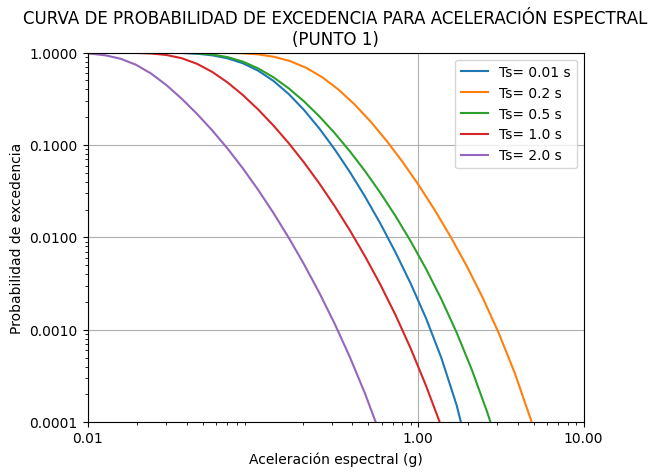

In [13]:
for coord in range(n_coord):
    fig, ax = plt.subplots()

    ax.set_title('CURVA DE PROBABILIDAD DE EXCEDENCIA PARA ACELERACIÓN ESPECTRAL\n(PUNTO ' + str(coord+1) + ')')

    ax.set_xscale('log')
    ax.set_xlim(0.01, 10.00)
    ax.set_xticks([0.01, 1.00, 10.00])
    ax.set_xlabel('Aceleración espectral (g)')

    ax.set_yscale('log')
    ax.set_ylim(0.0001, 1)
    ax.set_yticks([0.0001, 0.001, 0.01, 0.1, 1])
    ax.set_ylabel('Probabilidad de excedencia')

    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

    for i in range(len(ts_values)):
        ax.plot(curves_df[coord].iloc[:, 2 * i], curves_df[coord].iloc[:, 2 * i + 1], label='Ts= ' + str(ts_values[i]) + ' s')

    ax.legend(loc='best')
    plt.grid(True)

    plt.savefig(dir_point_routes[coord] + '/Hazard Curve Mean.png')

# Generación: Uniform Hazard Spectrum

In [14]:
uhs_tables = []

for coord in range(n_coord):
    uhs_table = pd.DataFrame()
    uhs_table['period'] = pd.Series(periods)

    for i, poe in enumerate(poes_header):
        uhs_table[poe] = hazard_uhs_mean_df.iloc[coord, i * n_periods : (i+1) * n_periods].reset_index(drop=True)

    uhs_table.to_excel(dir_point_routes[coord] + '/Hazard UHS Mean.xlsx', index=False)

    uhs_tables.append(uhs_table)


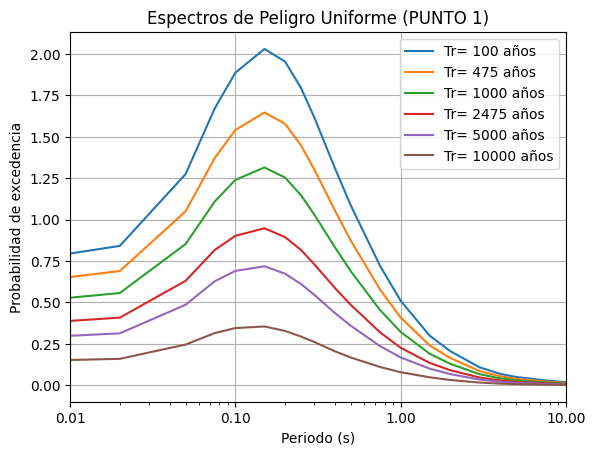

In [15]:
for coord in range(n_coord):
    fig, ax = plt.subplots()

    ax.set_title('Espectros de Peligro Uniforme (PUNTO ' + str(coord+1) + ')')

    ax.set_xscale('log')
    ax.set_xlim(0.01, 10.00)
    ax.set_xticks([0.01, 0.10, 1.00, 10.00])
    ax.set_xlabel('Periodo (s)')

    #ax.set_ylim(0.0001, 1)
    #ax.set_yticks([0.0001, 0.001, 0.01, 0.1, 1])
    ax.set_ylabel('Probabilidad de excedencia')

    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

    for i, poe in enumerate(reversed(poes_header)):
        ax.plot(uhs_tables[coord]['period'], uhs_tables[coord][poe], label=tr_dict[poes[i]])

    ax.legend(loc='best')
    plt.grid(True)

    plt.savefig(dir_point_routes[coord] + '/Hazard UHS Mean.png')
    plt.show()